# LSTM

Until now, I have been utilizing classical machine learning and a feature set. I found that my custom feature set caps at around 0.76-0.77. Then, I tried TFIDF and classical ML models. I found that they do present promise; however, they seem to also not be able to break the 0.80 boundary. In this notebook, I am doing to try to utilize deep learning approaches. Specifically, I will create a vocabulary and try to utilize a LSTM and see if it performs better.

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from nltk.stem import SnowballStemmer
from tensorflow import keras
from keras.utils import pad_sequences
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score

tqdm.pandas()
%matplotlib inline

In [ ]:
# Getting the essays and the labels
# data = pd.read_csv('../prepared_training_set.csv') -> for repo
data = pd.read_csv('prepared_training_set.csv') # for colab
essays = data['essay']
labels = data['LLM_written']

In [ ]:
# Creating the tokenizer and stemmer
tokenizer = get_tokenizer('spacy','en_core_web_sm')
stemmer = SnowballStemmer(language='english')

In [ ]:
# A function to tokenize and stem each essay
def preprocess_essays(essay:str) -> list:
    prepared_essay = []
    # Preprocessing the essay a bit
    preprocess_essay = essay.replace('\n',"")
    preprocess_essay = essay.replace('\t',"")
    tokenized = tokenizer(essay.replace('\n',""))

    # Getting the lemmas
    prepared_essay = [stemmer.stem(token) for token in tokenized]

    return prepared_essay

In [ ]:
# Finding the shape of the longest and shortest tokenized essays
def length(essay:list) -> int:
    return len(essay)

In [ ]:
# Getting the tokenized essays
tokenized_essays_df = pd.DataFrame()
tokenized_essays_df['essay'] = essays.progress_apply(preprocess_essays)
tokenized_essays_df['length'] = tokenized_essays_df['essay'].progress_apply(length)

100%|██████████| 49929/49929 [00:00<00:00, 828162.31it/s]


Using stemming instead of lemmatization because lemmatization would take too long (around 2-5 hours!!!). This is because lemmatization works on utilizing the POS tag along with the word (stripping prefixes and suffixes) to try to find an appropriate lemma to "bucket" the word in. This process is computationally expensive as the algorithm would look in a massive dictionary for an appropriate lemma. Stemming follows a set of rules and cuts off the ending. Stemming isn't as accurate, but it works much faster. Will help for a good solution.

In [ ]:
tokenized_essays_df['length'].describe()

count    49929.000000
mean       495.305754
std        471.085565
min         52.000000
25%        303.000000
50%        418.000000
75%        556.000000
max      22194.000000
Name: length, dtype: float64

From this analysis, a max token length of 575 should work. This cap would allow approximately 75% of the essays to not be truncated. I will have to add padding.

In [ ]:
# A function to yield each essay -> creates an iterator
def yield_essays(essays):
    for essay in essays:
        yield essay

In [ ]:
# Building the vocabulary -> vocab will have the 5000 most popular tokens along with an unknown token
vocabulary = build_vocab_from_iterator(yield_essays(tokenized_essays_df['essay']),specials=['<unk>','<pad>'],special_first=True,max_tokens=25000)
vocabulary.set_default_index(vocabulary['<unk>']) # Setting the default index as the index of the unknown

In [ ]:
# Creating the training data by inputting the essays through the vocabulary
def put_through_vocab(essay):
    return vocabulary(essay)

essays_through_vocab = tokenized_essays_df['essay'].progress_apply(put_through_vocab)

100%|██████████| 49929/49929 [00:03<00:00, 15336.16it/s]


In [ ]:
# Padding the sequences and truncating
padded_essays = pad_sequences(essays_through_vocab.tolist(),maxlen=500,padding='post',truncating='post',value=vocabulary['<pad>'])
padded_essays.shape

(49929, 500)

In [ ]:
# Model
class Model(nn.Module):
    def __init__(self,embed_size=250,hidden_size=250,dropout_rate=0.2):
        super().__init__()

        # Model layers
        self.embedding = nn.Embedding(25000,embed_size,padding_idx=vocabulary['<pad>'])
        self.lstm = nn.LSTM(embed_size,hidden_size,num_layers=2,bias=True,batch_first=True,bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(2*hidden_size,1,bias=True)

    # Forward method
    def forward(self,X):
        out = self.embedding(X)
        output,(_,_) = self.lstm(out)
        out = self.dropout(output[:,-1,:])
        return nn.functional.sigmoid(self.fc1(out))

In [ ]:
# Getting GPU
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
# Putting the data into a data loader for training
padded_essays_tensor = torch.from_numpy(padded_essays)
labels_tensor = torch.from_numpy(labels.values)

training_data = TensorDataset(padded_essays_tensor,labels_tensor)
training_dataloader = DataLoader(training_data,batch_size=32,shuffle=True)

In [ ]:
# Setting up the training
model = Model(embed_size=250,hidden_size=128,dropout_rate=0.3)
optimizer = torch.optim.Adam(model.parameters(),0.003)
loss_function = nn.BCELoss()
EPOCHS = 5
history = []
model.to(device)
model

Model(
  (embedding): Embedding(25000, 250, padding_idx=1)
  (lstm): LSTM(250, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
# Iterating and training
model.train()
for epoch in range(EPOCHS):
    epoch_loss = 0
    print(f'Starting EPOCH {epoch}...')
    for X,y in tqdm(training_dataloader):
        # Model predictions
        X = X.to(device)
        y = y.to(device)
        pred = model(X)

        # Loss function
        loss = loss_function(pred,y.float().view(-1,1))

        # Calculating the gradients
        loss.backward()

        # Taking a step with the optimizer
        optimizer.step()

        # Zeroing out optimizer
        optimizer.zero_grad()

        # Adding the loss to the epoch loss
        epoch_loss += loss.item()

    # Adding the loss to the history
    print(f'EPOCH {epoch} LOSS: {epoch_loss / len(training_data)}')
    print()
    history.append(epoch_loss / len(training_data))

Starting EPOCH 0...


100%|██████████| 1561/1561 [00:31<00:00, 48.84it/s]


EPOCH 0 LOSS: 0.0062405897014213285

Starting EPOCH 1...


100%|██████████| 1561/1561 [00:31<00:00, 49.75it/s]


EPOCH 1 LOSS: 0.0023348798708077508

Starting EPOCH 2...


100%|██████████| 1561/1561 [00:31<00:00, 49.72it/s]


EPOCH 2 LOSS: 0.0013538418786371211

Starting EPOCH 3...


100%|██████████| 1561/1561 [00:31<00:00, 49.44it/s]


EPOCH 3 LOSS: 0.0013179421203934488

Starting EPOCH 4...


100%|██████████| 1561/1561 [00:31<00:00, 49.45it/s]

EPOCH 4 LOSS: 0.0011684392764806705



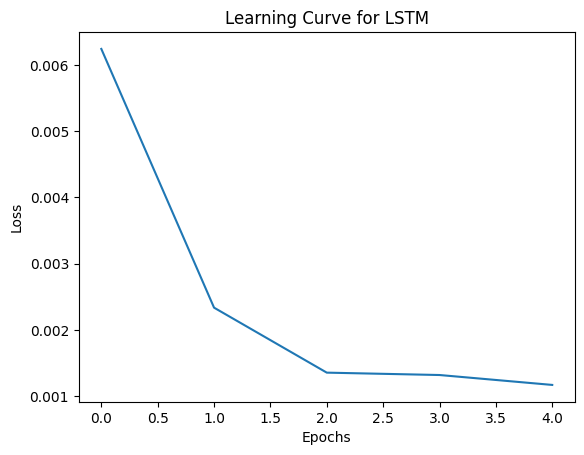

In [ ]:
# Plotting the learning curve
plt.title('Learning Curve for LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history)
plt.show()

In [ ]:
# Performing inference
predictions = None
targets = None
model.eval() # Setting model in eval mode
for X,y in training_dataloader:
  X = X.to(device)

  if predictions is None:
    predictions = model(X).cpu().detach().numpy()
  else:
    batch_pred = model(X).cpu().detach().numpy()
    predictions = np.append(predictions,batch_pred,axis=0)

  # Getting the targets
  if targets is None:
    targets = y.numpy()
  else:
    targets = np.append(targets,y.numpy(),axis=0)

predictions

array([[2.8033494e-03],
       [4.0126978e-03],
       [2.5288668e-04],
       ...,
       [9.9983239e-01],
       [5.5070600e-06],
       [1.6324522e-04]], dtype=float32)

In [ ]:
# Checking ROC AUC Score
print('ROC AUC on Training Set:')
print(roc_auc_score(targets,predictions))

ROC AUC on Training Set:
0.999527368121411


In [ ]:
# Saving model and vocabulary
torch.save(model.state_dict(),'lstm.pt')
torch.save(vocabulary,'vocab.pt')